The basic shape of ADSR is explained here: [http://dsp.stackexchange.com/questions/2555/help-with-equations-for-exponential-adsr-envelope](http://dsp.stackexchange.com/questions/2555/help-with-equations-for-exponential-adsr-envelope).

In this post, we will implement two different types of ADSR: a linear one and an exponential one.

How will we model our ADSR? We will only consider sound lengths between 0 and 1. Therefore, the periods of ADSR have to sum to 1. Our ADSR will therefore be coded by three points which will be computed by the parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
class linear_ADSR:
    def __init__(self, attack_time, decay_time, sustain_time, release_time,
                 attack_gain, sustain_gain):
        """
        instantiates class for linear ADSR
        """
        self.attack_time = attack_time
        self.decay_time = decay_time
        self.sustain_time = sustain_time
        self.release_time = release_time
        self.attack_gain = attack_gain
        self.sustain_gain = sustain_gain
        
        self.computed = False
        
    def compute_waveform(self):
        """
        computes the waveform shape
        """
        t = np.array([self.attack_time, self.decay_time, self.sustain_time, self.release_time])
        t = np.cumsum(t.astype(np.float))
        t /= t[-1]
        t = np.insert(t, 0, 0.)
        
        self.waveform = np.vstack((t,
                                   np.array([0., self.attack_gain, self.sustain_gain, self.sustain_gain, 0.])))
        
    def evaluate_waveform(self, t):
        """
        allows one to evaluate the ADSR time filter at times t
        it is assumed that the time window goes from 0 to 1
        """
        if not self.computed:
            self.compute_waveform()
            
        normalized_t = (t - t[0]) / (t[-1] - t[0])
        
        from scipy import interpolate
        interpolator = interpolate.interp1d(self.waveform[0, :], self.waveform[1, :],
                                           bounds_error=False,
                                           fill_value=0.,
                                           assume_sorted=True)
        return interpolator(normalized_t)
    
    def plot(self, ax, t):
        """
        plots the waveform to the axis supplied to the method
        """
        if not self.computed:
            self.compute_waveform()
        

We can now test this class:

In [48]:
lin_adsr = linear_ADSR(0.5, 1, 3, 1, 2, 1)

In [49]:
lin_adsr.compute_waveform()

In [50]:
lin_adsr.waveform

array([[ 0.        ,  0.09090909,  0.27272727,  0.81818182,  1.        ],
       [ 0.        ,  2.        ,  1.        ,  1.        ,  0.        ]])

In [51]:
t = np.linspace(0, 1, 300)

In [52]:
wf = lin_adsr.evaluate_waveform(t)

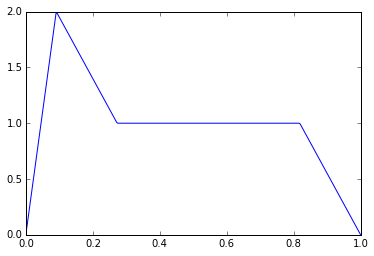

In [53]:
plt.plot(t, wf)

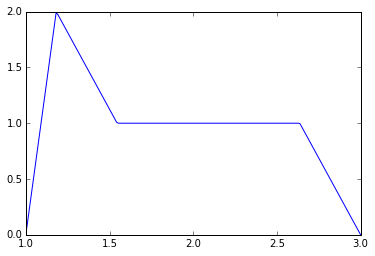

In [68]:
t = np.linspace(1, 3, 200)
wf = lin_adsr.evaluate_waveform(t)
plt.plot(t, wf)

Now we can convolve this shape with any pulse shape. Let's start with a sample sinusoid sound.

In [63]:
f = 100
sample_freq = 5000
t = np.arange(0, 1, 1./sample_freq)
snd = np.sin(2 * np.pi * f * t) * lin_adsr.evaluate_waveform(t)

In [64]:
from IPython.display import Audio
Audio(snd, rate=sample_freq)

The same thing can be done with a square wave.

In [65]:
from scipy.signal import square

In [66]:
snd = square(2 * np.pi * f * t) * lin_adsr.evaluate_waveform(t)
Audio(snd, rate=sample_freq)

We can build an interesting waveform using this:

In [79]:
lin_adsr = linear_ADSR(0.5, 2, 5, 0.5, 6, 1)
f = 243
sample_freq = 5000
t = np.arange(0, 0.5, 1./sample_freq) 
wf1 = square(2 * np.pi * f * t) * lin_adsr.evaluate_waveform(t)
wf2 = square(2 * np.pi * 0.8 * f * t) * lin_adsr.evaluate_waveform(t)
snd = np.concatenate((wf1, wf1, wf1, wf2))
Audio(snd, rate=sample_freq)

Building upon the previous code, we can program a nice sounding exponential ADSR. The trick is to change the way of evaluating the waveform and to plugin an exponential waveform. A general formula for the **increasing** exponential waveform is as follows:

$$
s(t) = A \left( 1 - \exp(-\frac{t}{\tau}) \right)
$$

in this expression $A$ is the target amplitude and $\tau$ is the time constant chosen so that $5 \tau$ is equal to the time interval of the given phase (attack, delay, sustain, release).

A general formula for the **decreasing** exponential waveform is as follows:

$$
s(t) = A \exp(-\frac{t}{\tau})
$$


In [105]:
class exponential_ADSR(linear_ADSR):
    def evaluate_waveform(self, t):
        """
        allows one to evaluate the ADSR time filter at times t
        it is assumed that the time window goes from 0 to 1
        """
        if not self.computed:
            self.compute_waveform()
            
        t = (t - t[0]) / (t[-1] - t[0])
        
        a = t < self.waveform[0, 1]
        d = (t > self.waveform[0, 1]) & (t < self.waveform[0, 2])
        s = (t > self.waveform[0, 2]) & (t < self.waveform[0, 3])
        r = t > self.waveform[0, 3]
        
        delta_t = self.waveform[0, 1:] - self.waveform[0, 0:-1]
        amps = self.waveform[1, 1:4]
        
        return np.ones_like(t) * (a * amps[0] * (1 - np.exp(-t / delta_t[0] * 5.)) + \
                                 d * ((amps[0] - amps[1]) * np.exp(-(t - t[d][0]) / delta_t[1] * 5.) + amps[1]) + \
                                 s *(amps[1]) + \
                                 r * (amps[2] * np.exp(-(t - t[r][0]) / delta_t[2] * 5.)))

In [125]:
expo_adsr = exponential_ADSR(1, 1, 2, 2, 3, 1)

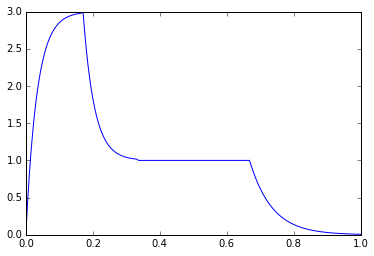

In [126]:
t = np.linspace(0, 1, 200)
wf = expo_adsr.evaluate_waveform(t)
plt.plot(t, wf)

Again, let's test the different signals:

In [127]:
f = 100
sample_freq = 5000
t = np.arange(0, 1, 1./sample_freq)
snd = np.sin(2 * np.pi * f * t) * expo_adsr.evaluate_waveform(t)
Audio(snd, rate=sample_freq)

In [128]:
snd = square(2 * np.pi * f * t) * expo_adsr.evaluate_waveform(t)
Audio(snd, rate=sample_freq)

In [129]:
expo_adsr = exponential_ADSR(0.5, 5, 5, 0.5, 4, 1)
f = 243
sample_freq = 5000
t = np.arange(0, 0.5, 1./sample_freq) 
wf1 = square(2 * np.pi * f * t) * expo_adsr.evaluate_waveform(t)
wf2 = square(2 * np.pi * 0.8 * f * t) * expo_adsr.evaluate_waveform(t)
snd = np.concatenate((wf1, wf1, wf1, wf2))
Audio(snd, rate=sample_freq)

Let's apply the knowledge of waveforms we gained to playing nice little melodies:

In [139]:
import re
from IPython.display import Audio, display

def play_melody(melody, adsr, sample_freq=10.e3, bpm=50):
    duration = re.compile("^[0-9]+")
    pitch = re.compile("[\D]+[\d]*") 
    measure_duration = 4 * 60. / bpm #usually it's 4/4 measures
    output = np.zeros((0,))
    for note in melody.split(','):
        # regexp matching
        duration_match = duration.findall(note)
        pitch_match = pitch.findall(note)
        
        # duration 
        if len(duration_match) == 0:
            t_max = 1/4.
        else:
            t_max = 1/float(duration_match[0])
        if "." in pitch_match[0]:
            t_max *= 1.5
            pitch_match[0] = "".join(pitch_match[0].split("."))
        t_max = t_max * measure_duration
        
        # pitch
        if pitch_match[0] == 'p':
            freq = 0
        else:
            if pitch_match[0][-1] in ["4", "5", "6", "7"]: # octave is known
                octave = ["4", "5", "6", "7"].index(pitch_match[0][-1]) + 4 
                height = pitch_match[0][:-1]
            else: # octave is not known
                octave = 5
                height = pitch_match[0]
            freq = 261.626 * 2 ** ((["c", "c#", "d", "d#", "e", "f", "f#", "g", "g#", "a", "a#", "b"].index(height) / 12. + octave - 4))  
            
        # generate sound
        t = np.arange(0, t_max, 1/sample_freq)
        wave = square(2 *np. pi * freq * t) * adsr.evaluate_waveform(t)
        
        # append to output
        output = np.hstack((output, wave))
    
    display(Audio(output, rate=sample_freq)) 

We have modified the function [from this post](http://flothesof.github.io/gameboy-sounds-in-python.html) to allow for a changing envelope function.

In [140]:
tetris = "e6,8b,8c6,8d6,16e6,16d6,8c6,8b,a,8a,8c6,e6,8d6,8c6,b,8b,8c6,d6,e6,c6,a,2a,8p,d6,8f6,a6,8g6,8f6,e6,8e6,8c6,e6,8d6,8c6,b,8b,8c6,d6,e6,c6,a,a"

In [141]:
play_melody(tetris, lin_adsr, bpm=140)

In [142]:
play_melody(tetris, expo_adsr, bpm=140)